In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
df = pd.read_csv("Synthetic_SBA_Loans.csv")

avg_score = df['Eligibility Score'].mean()
below_avg = df[df['Eligibility Score'] < avg_score]

n_decline = int(0.25 * len(df))
decline_indices = below_avg.sample(n=n_decline, random_state=42).index
df.loc[decline_indices, 'Eligibility'] = '0'
eligibility_counts = df['Eligibility'].value_counts()
eligibility_counts

Eligibility
['7(a)', '504']    446766
0                  148921
Name: count, dtype: int64

In [4]:
df['Eligibility'] = df['Eligibility'].apply(lambda x: 1 if x == "['7(a)', '504']" else 0)
df['Eligibility'].value_counts()

Eligibility
1    446766
0    148921
Name: count, dtype: int64

In [5]:
X = df.drop(columns=['Eligibility'])
y = df['Eligibility']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train.shape, X_test.shape, y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

((476549, 46),
 (119138, 46),
 Eligibility
 1    0.750001
 0    0.249999
 Name: proportion, dtype: float64,
 Eligibility
 1    0.750004
 0    0.249996
 Name: proportion, dtype: float64)

In [6]:
drop_cols = ['Applicant ID', 'Location', 'Country', 'NAICS']
X_train_cleaned = X_train.drop(columns=drop_cols + ['Eligibility Score'])
X_test_cleaned = X_test.drop(columns=drop_cols + ['Eligibility Score'])

categorical_cols = ['Business Structure']
numerical_cols = X_train_cleaned.select_dtypes(include=['int64', 'float64', 'bool']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ]
)

preprocessing_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train_cleaned)
X_test_preprocessed = preprocessing_pipeline.transform(X_test_cleaned)

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

lr = 0.0005
epoch = 20

early_stopping = EarlyStopping(
    monitor='val_loss',   
    patience=3,           
    restore_best_weights=True 
)

input_shape = X_train_preprocessed.shape[1]

model = Sequential([
    Dense(128, activation='relu', input_shape=(input_shape,)),
    BatchNormalization(),
    Dropout(0.2),  
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  
])

model.compile(optimizer=Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train_preprocessed, y_train,
                    validation_split=0.1,
                    epochs=epoch,
                    batch_size=128,
                    verbose=1,
                    callbacks=[early_stopping]) 

test_loss, test_acc = model.evaluate(X_test_preprocessed, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/20


c:\Users\Jun\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3351/3351 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.7455 - loss: 0.4639 - val_accuracy: 0.7572 - val_loss: 0.4144
Epoch 2/20
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7568 - loss: 0.4182 - val_accuracy: 0.7603 - val_loss: 0.4045
Epoch 3/20
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7587 - loss: 0.4106 - val_accuracy: 0.7619 - val_loss: 0.4003
Epoch 4/20
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7600 - loss: 0.4072 - val_accuracy: 0.7643 - val_loss: 0.3979
Epoch 5/20
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7629 - loss: 0.4021 - val_accuracy: 0.7640 - val_loss: 0.3964
Epoch 6/20
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7628 - loss: 0.4010 - val_accuracy: 0.7648 - val_loss: 0.3951
Epoch 7/20
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7610 - loss: 0.4008 - val_accuracy: 0.7641 - val_loss: 0.3932
Epoch 8/20
3351/3351 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7639 - loss: 0.3978 - val_accurac

In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_preprocessed, y_train)

feature_importances = rf_model.feature_importances_
num_features = preprocessing_pipeline.named_steps['preprocessor'].transformers_[0][2]  
cat_feature_names = preprocessing_pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out()  
feature_names = list(num_features) + list(cat_feature_names)

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df.head(20))




                         Feature  Importance
5          Personal Credit Score    0.076581
13   Business Debt (latest year)    0.056965
22             Years in Business    0.053641
16             NOI (latest year)    0.049912
20           Industry Experience    0.045714
9   Annual Revenue (latest year)    0.044631
21         Managerial Experience    0.044433
10             Net Profit Margin    0.043161
24                   Loan Amount    0.041571
19            DSCR (latest year)    0.040472
7   Annual Revenue (2 years ago)    0.035900
8    Annual Revenue (1 year ago)    0.035880
11   Business Debt (2 years ago)    0.034663
14             NOI (2 years ago)    0.034662
15              NOI (1 year ago)    0.034585
12    Business Debt (1 year ago)    0.034420
17            DSCR (2 years ago)    0.034273
18             DSCR (1 year ago)    0.034159
6          Business Credit Score    0.030110
27           Acquisition Request    0.028831


3724/3724 ━━━━━━━━━━━━━━━━━━━━ 2s 569us/step
Brier Score (lower is better): 0.1348


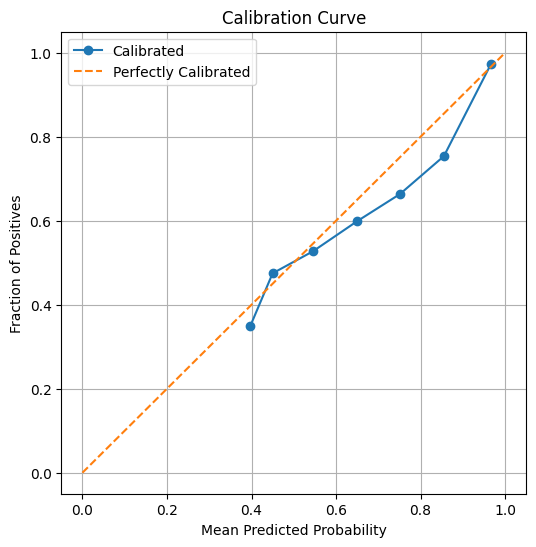

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

val_probs = model.predict(X_test_preprocessed)
val_probs = val_probs.flatten()  

calibrator = LogisticRegression()
calibrator.fit(val_probs.reshape(-1, 1), y_test)
calibrated_probs = calibrator.predict_proba(val_probs.reshape(-1, 1))[:, 1]

brier = brier_score_loss(y_test, calibrated_probs)
print(f"Brier Score (lower is better): {brier:.4f}")

prob_true, prob_pred = calibration_curve(y_test, calibrated_probs, n_bins=10)

plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibrated')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train_preprocessed, y_train)

nn_probs = model.predict(X_test_preprocessed).flatten() 
xgb_probs = xgb_model.predict_proba(X_test_preprocessed)[:, 1]

blended_probs = (nn_probs + xgb_probs) / 2
blended_preds = (blended_probs >= 0.5).astype(int)  

blended_accuracy = accuracy_score(y_test, blended_preds)
blended_accuracy


3724/3724 ━━━━━━━━━━━━━━━━━━━━ 3s 694us/step


0.7614866793130656

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train_preprocessed, y_train)

nn_train_probs = model.predict(X_train_preprocessed).flatten()  
xgb_train_probs = xgb_model.predict_proba(X_train_preprocessed)[:, 1]  

meta_X_train = np.column_stack((nn_train_probs, xgb_train_probs))
meta_y_train = y_train 
meta_learner = LogisticRegression()
meta_learner.fit(meta_X_train, meta_y_train)

nn_test_probs = model.predict(X_test_preprocessed).flatten()
xgb_test_probs = xgb_model.predict_proba(X_test_preprocessed)[:, 1]

meta_X_test = np.column_stack((nn_test_probs, xgb_test_probs))
meta_preds = meta_learner.predict(meta_X_test)
meta_accuracy = accuracy_score(y_test, meta_preds)
print(f"Meta-Learner Test Accuracy: {meta_accuracy:.4f}")


14893/14893 ━━━━━━━━━━━━━━━━━━━━ 9s 573us/step
3724/3724 ━━━━━━━━━━━━━━━━━━━━ 2s 571us/step
Meta-Learner Test Accuracy: 0.7659


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train_preprocessed, y_train)

nn_train_probs = model.predict(X_train_preprocessed).flatten()  
xgb_train_probs = xgb_model.predict_proba(X_train_preprocessed)[:, 1]  

meta_X_train = np.column_stack((nn_train_probs, xgb_train_probs))
meta_y_train = y_train  # True labels
meta_learner = RandomForestClassifier(n_estimators=100, random_state=42)
meta_learner.fit(meta_X_train, meta_y_train)

nn_test_probs = model.predict(X_test_preprocessed).flatten()
xgb_test_probs = xgb_model.predict_proba(X_test_preprocessed)[:, 1]

meta_X_test = np.column_stack((nn_test_probs, xgb_test_probs))
meta_preds = meta_learner.predict(meta_X_test)
meta_accuracy = accuracy_score(y_test, meta_preds)
print(f"Advanced Meta-Learner (Random Forest) Test Accuracy: {meta_accuracy:.4f}")


14893/14893 ━━━━━━━━━━━━━━━━━━━━ 11s 727us/step
3724/3724 ━━━━━━━━━━━━━━━━━━━━ 3s 742us/step
Advanced Meta-Learner (Random Forest) Test Accuracy: 0.7590


In [13]:
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lgb_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.05, random_state=42)
lgb_model.fit(X_train_preprocessed, y_train)

nn_train_probs = model.predict(X_train_preprocessed).flatten()
lgb_train_probs = lgb_model.predict_proba(X_train_preprocessed)[:, 1]

meta_X_train = np.column_stack((nn_train_probs, lgb_train_probs))
meta_learner = LogisticRegression()
meta_learner.fit(meta_X_train, y_train)

nn_test_probs = model.predict(X_test_preprocessed).flatten()
lgb_test_probs = lgb_model.predict_proba(X_test_preprocessed)[:, 1]

meta_X_test = np.column_stack((nn_test_probs, lgb_test_probs))
meta_preds = meta_learner.predict(meta_X_test)
meta_accuracy = accuracy_score(y_test, meta_preds)

print(f"Meta-Learner (NN + LightGBM) Test Accuracy: {meta_accuracy:.4f}")


[LightGBM] [Info] Number of positive: 357412, number of negative: 119137
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3662
[LightGBM] [Info] Number of data points in the train set: 476549, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.750001 -> initscore=1.098615
[LightGBM] [Info] Start training from score 1.098615
14893/14893 ━━━━━━━━━━━━━━━━━━━━ 10s 697us/step


c:\Users\Jun\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


3724/3724 ━━━━━━━━━━━━━━━━━━━━ 2s 589us/step
Meta-Learner (NN + LightGBM) Test Accuracy: 0.7660


c:\Users\Jun\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [14]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

nn_train_probs = model.predict(X_train_preprocessed).flatten()
xgb_train_probs = xgb_model.predict_proba(X_train_preprocessed)[:, 1]
lgb_train_probs = lgb_model.predict_proba(X_train_preprocessed)[:, 1]

meta_X_train = np.column_stack((nn_train_probs, xgb_train_probs, lgb_train_probs))
meta_y_train = y_train

meta_learner = LogisticRegression()
meta_learner.fit(meta_X_train, meta_y_train)

nn_test_probs = model.predict(X_test_preprocessed).flatten()
xgb_test_probs = xgb_model.predict_proba(X_test_preprocessed)[:, 1]
lgb_test_probs = lgb_model.predict_proba(X_test_preprocessed)[:, 1]

meta_X_test = np.column_stack((nn_test_probs, xgb_test_probs, lgb_test_probs))
meta_preds = meta_learner.predict(meta_X_test)
meta_accuracy = accuracy_score(y_test, meta_preds)
print(f"Meta-Learner (NN + XGB + LGBM) Test Accuracy: {meta_accuracy:.4f}")



14893/14893 ━━━━━━━━━━━━━━━━━━━━ 10s 638us/step


c:\Users\Jun\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


3724/3724 ━━━━━━━━━━━━━━━━━━━━ 2s 605us/step
Meta-Learner (NN + XGB + LGBM) Test Accuracy: 0.7659


c:\Users\Jun\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [15]:
import joblib

print(meta_learner.coef_)
model.save("neural_net_model.h5")  
joblib.dump(xgb_model, "xgboost_model.pkl") 
joblib.dump(meta_learner, "meta_learner.pkl")  



[[5.41405828 1.22397942 1.37478358]]


['meta_learner.pkl']

In [16]:

# Step 1: Rebuild the preprocessing pipeline using training data (df_train)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
df_train = pd.read_csv("Synthetic_SBA_Loans.csv")

drop_cols = ['Applicant ID', 'Country', 'Location', 'NAICS', 'Eligibility Score']
categorical_cols = ['Business Structure']

numerical_cols = df_train.drop(columns=drop_cols + categorical_cols + ['Eligibility'], errors='ignore')                         .select_dtypes(include=['int64', 'float64', 'bool']).columns.tolist()

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
])

X_train = df_train.drop(columns=drop_cols + ['Eligibility'], errors='ignore')
X_train_preprocessed = preprocessor.fit_transform(X_train)

import joblib
joblib.dump(preprocessor, 'preprocessor.pkl')


['preprocessor.pkl']

In [17]:

# Step 2: Load trained models and preprocess new test data
import tensorflow as tf
import pandas as pd
import numpy as np
import joblib

# Load models
nn_model = tf.keras.models.load_model("neural_net_model.h5")
xgb_model = joblib.load("xgboost_model.pkl")
meta_learner = joblib.load("meta_learner.pkl")
preprocessor = joblib.load("preprocessor.pkl")

# Load and preprocess new data
df_new = pd.read_csv("Synthetic_SBA_Loans_test.csv")
df_new_cleaned = df_new.drop(columns=drop_cols, errors='ignore')
X_new_preprocessed = preprocessor.transform(df_new_cleaned)


In [18]:
meta_X_train = np.column_stack((nn_train_probs, xgb_train_probs))
meta_learner = LogisticRegression()
meta_learner.fit(meta_X_train, y_train)

# Then save it again
import joblib
joblib.dump(meta_learner, "meta_learner.pkl")


['meta_learner.pkl']

In [19]:

# Step 3: Generate predictions using NN + XGB and use meta-learner for final decision
nn_probs = nn_model.predict(X_new_preprocessed).flatten()
xgb_probs = xgb_model.predict_proba(X_new_preprocessed)[:, 1]

# Stack for meta-learner
meta_X = np.column_stack((nn_probs, xgb_probs))
final_preds = meta_learner.predict(meta_X)

# Append results and save
df_new["Predicted_Eligibility"] = final_preds
df_new.to_csv("Predicted_SBA_Loans.csv", index=False)
print("✅ Predictions complete. Output saved to 'Predicted_SBA_Loans.csv'")


190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step
✅ Predictions complete. Output saved to 'Predicted_SBA_Loans.csv'
